# Experiments for Watts--Strogatz Graph

## Imports

In [2]:
%load_ext autoreload
%autoreload 2

import os
import sys

from collections import OrderedDict
import logging
import math

from matplotlib import pyplot as plt
import networkx as nx
import numpy as np

import torch
from torchdiffeq import odeint, odeint_adjoint

sys.path.append('../../')

# Baseline imports
from gd_controller import AdjointGD
from dynamics_driver import ForwardKuramotoDynamics, BackwardKuramotoDynamics

# Nodec imports
from neural_net import EluTimeControl, TrainingAlgorithm

# Various Utilities
from utilities import evaluate, calculate_critical_coupling_constant, comparison_plot, state_plot
from nnc.helpers.torch_utils.oscillators import order_parameter_cos

logging.getLogger().setLevel(logging.CRITICAL) # set to info to look at loss values etc.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load graph parameters
Basic setup for calculations, graph, number of nodes, etc.

In [3]:
dtype = torch.float32
device = 'cpu'
graph_type = 'watts_strogatz'
adjacency_matrix = torch.load('../../data/'+graph_type+'_adjacency.pt')
parameters = torch.load('../../data/parameters.pt')
# driver vector is a column vector with 1 value for driver nodes
# and 0 for non drivers.

result_folder = '../../results/' + graph_type + os.path.sep
os.makedirs(result_folder, exist_ok=True)

## Load dynamics parameters
Load natural frequencies and initial states which are common for all graphs and also calculate the coupling constant which is different per graph. We use a coupling constant value that is $10%$ of the critical coupling constant value.

In [4]:
total_time = parameters['total_time']
total_time = 5
natural_frequencies = parameters['natural_frequencies']

critical_coupling_constant = calculate_critical_coupling_constant(adjacency_matrix, natural_frequencies)
coupling_constant = 0.15*critical_coupling_constant
theta_0 = parameters['theta_0']

## NODEC
We now train NODEC with a shallow neural network. We initialize the parameters in a deterministic manner, and use stochastic gradient descent to train it. The learning rate, number of epochs and neural architecture may change per graph. We use different fractions of driver nodes.

In [7]:
fractions = np.linspace(0.9,1,10)

order_parameter_mean = []
order_parameter_std = []
samples = 1000

for p in fractions:
    sample_arr = []
    for i in range(samples):
        print(p,i)
        driver_nodes = int(p*adjacency_matrix.shape[0])
        driver_vector = torch.zeros([adjacency_matrix.shape[0],1])
        idx = torch.randperm(len(driver_vector))[:driver_nodes]
        driver_vector[idx] = 1        
        
        forward_dynamics = ForwardKuramotoDynamics(adjacency_matrix, 
                                                   driver_vector, 
                                                   coupling_constant, 
                                                   natural_frequencies
                                                  )
        backward_dynamics = BackwardKuramotoDynamics(adjacency_matrix, 
                                                     driver_vector, 
                                                     coupling_constant, 
                                                     natural_frequencies
                                                    )

        neural_net = EluTimeControl([2])
        for parameter in neural_net.parameters():
            parameter.data = torch.ones_like(parameter.data)/1000 # deterministic init!
        train_algo = TrainingAlgorithm(neural_net, forward_dynamics)
        best_model = train_algo.train(theta_0, total_time, epochs=3, lr=1)

        control_trajectory, state_trajectory =\
        evaluate(forward_dynamics, theta_0, best_model, total_time, 100)
        nn_control = torch.cat(control_trajectory).squeeze().cpu().detach().numpy()
        nn_states = torch.cat(state_trajectory).cpu().detach().numpy()
        nn_e = (nn_control**2).cumsum(-1)
        nn_r = order_parameter_cos(torch.tensor(nn_states)).cpu().numpy()
        sample_arr.append(nn_r[-1])
    
    order_parameter_mean.append(np.mean(sample_arr))
    order_parameter_std.append(np.std(sample_arr,ddof=1))

0.9 0
0.9 1
0.9 2
0.9 3
0.9 4
0.9 5
0.9 6
0.9 7
0.9 8
0.9 9
0.9 10
0.9 11
0.9 12
0.9 13
0.9 14
0.9 15
0.9 16
0.9 17
0.9 18
0.9 19
0.9 20
0.9 21
0.9 22
0.9 23
0.9 24
0.9 25
0.9 26
0.9 27
0.9 28
0.9 29
0.9 30
0.9 31
0.9 32
0.9 33
0.9 34
0.9 35
0.9 36
0.9 37
0.9 38
0.9 39
0.9 40
0.9 41
0.9 42
0.9 43
0.9 44
0.9 45
0.9 46
0.9 47
0.9 48
0.9 49
0.9 50
0.9 51
0.9 52
0.9 53
0.9 54
0.9 55
0.9 56
0.9 57
0.9 58
0.9 59
0.9 60
0.9 61
0.9 62
0.9 63
0.9 64
0.9 65
0.9 66
0.9 67
0.9 68
0.9 69
0.9 70
0.9 71
0.9 72
0.9 73
0.9 74
0.9 75
0.9 76
0.9 77
0.9 78
0.9 79
0.9 80
0.9 81
0.9 82
0.9 83
0.9 84
0.9 85
0.9 86
0.9 87
0.9 88
0.9 89
0.9 90
0.9 91
0.9 92
0.9 93
0.9 94
0.9 95
0.9 96
0.9 97
0.9 98
0.9 99
0.9 100
0.9 101
0.9 102
0.9 103
0.9 104
0.9 105
0.9 106
0.9 107
0.9 108
0.9 109
0.9 110
0.9 111
0.9 112
0.9 113
0.9 114
0.9 115
0.9 116
0.9 117
0.9 118
0.9 119
0.9 120
0.9 121
0.9 122
0.9 123
0.9 124
0.9 125
0.9 126
0.9 127
0.9 128
0.9 129
0.9 130
0.9 131
0.9 132
0.9 133
0.9 134
0.9 135
0.9 136
0.9 137
0.9 13

0.9111111111111111 15
0.9111111111111111 16
0.9111111111111111 17
0.9111111111111111 18
0.9111111111111111 19
0.9111111111111111 20
0.9111111111111111 21
0.9111111111111111 22
0.9111111111111111 23
0.9111111111111111 24
0.9111111111111111 25
0.9111111111111111 26
0.9111111111111111 27
0.9111111111111111 28
0.9111111111111111 29
0.9111111111111111 30
0.9111111111111111 31
0.9111111111111111 32
0.9111111111111111 33
0.9111111111111111 34
0.9111111111111111 35
0.9111111111111111 36
0.9111111111111111 37
0.9111111111111111 38
0.9111111111111111 39
0.9111111111111111 40
0.9111111111111111 41
0.9111111111111111 42
0.9111111111111111 43
0.9111111111111111 44
0.9111111111111111 45
0.9111111111111111 46
0.9111111111111111 47
0.9111111111111111 48
0.9111111111111111 49
0.9111111111111111 50
0.9111111111111111 51
0.9111111111111111 52
0.9111111111111111 53
0.9111111111111111 54
0.9111111111111111 55
0.9111111111111111 56
0.9111111111111111 57
0.9111111111111111 58
0.9111111111111111 59
0.91111111

0.9111111111111111 375
0.9111111111111111 376
0.9111111111111111 377
0.9111111111111111 378
0.9111111111111111 379
0.9111111111111111 380
0.9111111111111111 381
0.9111111111111111 382
0.9111111111111111 383
0.9111111111111111 384
0.9111111111111111 385
0.9111111111111111 386
0.9111111111111111 387
0.9111111111111111 388
0.9111111111111111 389
0.9111111111111111 390
0.9111111111111111 391
0.9111111111111111 392
0.9111111111111111 393
0.9111111111111111 394
0.9111111111111111 395
0.9111111111111111 396
0.9111111111111111 397
0.9111111111111111 398
0.9111111111111111 399
0.9111111111111111 400
0.9111111111111111 401
0.9111111111111111 402
0.9111111111111111 403
0.9111111111111111 404
0.9111111111111111 405
0.9111111111111111 406
0.9111111111111111 407
0.9111111111111111 408
0.9111111111111111 409
0.9111111111111111 410
0.9111111111111111 411
0.9111111111111111 412
0.9111111111111111 413
0.9111111111111111 414
0.9111111111111111 415
0.9111111111111111 416
0.9111111111111111 417
0.911111111

0.9111111111111111 732
0.9111111111111111 733
0.9111111111111111 734
0.9111111111111111 735
0.9111111111111111 736
0.9111111111111111 737
0.9111111111111111 738
0.9111111111111111 739
0.9111111111111111 740
0.9111111111111111 741
0.9111111111111111 742
0.9111111111111111 743
0.9111111111111111 744
0.9111111111111111 745
0.9111111111111111 746
0.9111111111111111 747
0.9111111111111111 748
0.9111111111111111 749
0.9111111111111111 750
0.9111111111111111 751
0.9111111111111111 752
0.9111111111111111 753
0.9111111111111111 754
0.9111111111111111 755
0.9111111111111111 756
0.9111111111111111 757
0.9111111111111111 758
0.9111111111111111 759
0.9111111111111111 760
0.9111111111111111 761
0.9111111111111111 762
0.9111111111111111 763
0.9111111111111111 764
0.9111111111111111 765
0.9111111111111111 766
0.9111111111111111 767
0.9111111111111111 768
0.9111111111111111 769
0.9111111111111111 770
0.9111111111111111 771
0.9111111111111111 772
0.9111111111111111 773
0.9111111111111111 774
0.911111111

0.9222222222222223 93
0.9222222222222223 94
0.9222222222222223 95
0.9222222222222223 96
0.9222222222222223 97
0.9222222222222223 98
0.9222222222222223 99
0.9222222222222223 100
0.9222222222222223 101
0.9222222222222223 102
0.9222222222222223 103
0.9222222222222223 104
0.9222222222222223 105
0.9222222222222223 106
0.9222222222222223 107
0.9222222222222223 108
0.9222222222222223 109
0.9222222222222223 110
0.9222222222222223 111
0.9222222222222223 112
0.9222222222222223 113
0.9222222222222223 114
0.9222222222222223 115
0.9222222222222223 116
0.9222222222222223 117
0.9222222222222223 118
0.9222222222222223 119
0.9222222222222223 120
0.9222222222222223 121
0.9222222222222223 122
0.9222222222222223 123
0.9222222222222223 124
0.9222222222222223 125
0.9222222222222223 126
0.9222222222222223 127
0.9222222222222223 128
0.9222222222222223 129
0.9222222222222223 130
0.9222222222222223 131
0.9222222222222223 132
0.9222222222222223 133
0.9222222222222223 134
0.9222222222222223 135
0.9222222222222223

0.9222222222222223 450
0.9222222222222223 451
0.9222222222222223 452
0.9222222222222223 453
0.9222222222222223 454
0.9222222222222223 455
0.9222222222222223 456
0.9222222222222223 457
0.9222222222222223 458
0.9222222222222223 459
0.9222222222222223 460
0.9222222222222223 461
0.9222222222222223 462
0.9222222222222223 463
0.9222222222222223 464
0.9222222222222223 465
0.9222222222222223 466
0.9222222222222223 467
0.9222222222222223 468
0.9222222222222223 469
0.9222222222222223 470
0.9222222222222223 471
0.9222222222222223 472
0.9222222222222223 473
0.9222222222222223 474
0.9222222222222223 475
0.9222222222222223 476
0.9222222222222223 477
0.9222222222222223 478
0.9222222222222223 479
0.9222222222222223 480
0.9222222222222223 481
0.9222222222222223 482
0.9222222222222223 483
0.9222222222222223 484
0.9222222222222223 485
0.9222222222222223 486
0.9222222222222223 487
0.9222222222222223 488
0.9222222222222223 489
0.9222222222222223 490
0.9222222222222223 491
0.9222222222222223 492
0.922222222

0.9222222222222223 807
0.9222222222222223 808
0.9222222222222223 809
0.9222222222222223 810
0.9222222222222223 811
0.9222222222222223 812
0.9222222222222223 813
0.9222222222222223 814
0.9222222222222223 815
0.9222222222222223 816
0.9222222222222223 817
0.9222222222222223 818
0.9222222222222223 819
0.9222222222222223 820
0.9222222222222223 821
0.9222222222222223 822
0.9222222222222223 823
0.9222222222222223 824
0.9222222222222223 825
0.9222222222222223 826
0.9222222222222223 827
0.9222222222222223 828
0.9222222222222223 829
0.9222222222222223 830
0.9222222222222223 831
0.9222222222222223 832
0.9222222222222223 833
0.9222222222222223 834
0.9222222222222223 835
0.9222222222222223 836
0.9222222222222223 837
0.9222222222222223 838
0.9222222222222223 839
0.9222222222222223 840
0.9222222222222223 841
0.9222222222222223 842
0.9222222222222223 843
0.9222222222222223 844
0.9222222222222223 845
0.9222222222222223 846
0.9222222222222223 847
0.9222222222222223 848
0.9222222222222223 849
0.922222222

0.9333333333333333 168
0.9333333333333333 169
0.9333333333333333 170
0.9333333333333333 171
0.9333333333333333 172
0.9333333333333333 173
0.9333333333333333 174
0.9333333333333333 175
0.9333333333333333 176
0.9333333333333333 177
0.9333333333333333 178
0.9333333333333333 179
0.9333333333333333 180
0.9333333333333333 181
0.9333333333333333 182
0.9333333333333333 183
0.9333333333333333 184
0.9333333333333333 185
0.9333333333333333 186
0.9333333333333333 187
0.9333333333333333 188
0.9333333333333333 189
0.9333333333333333 190
0.9333333333333333 191
0.9333333333333333 192
0.9333333333333333 193
0.9333333333333333 194
0.9333333333333333 195
0.9333333333333333 196
0.9333333333333333 197
0.9333333333333333 198
0.9333333333333333 199
0.9333333333333333 200
0.9333333333333333 201
0.9333333333333333 202
0.9333333333333333 203
0.9333333333333333 204
0.9333333333333333 205
0.9333333333333333 206
0.9333333333333333 207
0.9333333333333333 208
0.9333333333333333 209
0.9333333333333333 210
0.933333333

0.9333333333333333 525
0.9333333333333333 526
0.9333333333333333 527
0.9333333333333333 528
0.9333333333333333 529
0.9333333333333333 530
0.9333333333333333 531
0.9333333333333333 532
0.9333333333333333 533
0.9333333333333333 534
0.9333333333333333 535
0.9333333333333333 536
0.9333333333333333 537
0.9333333333333333 538
0.9333333333333333 539
0.9333333333333333 540
0.9333333333333333 541
0.9333333333333333 542
0.9333333333333333 543
0.9333333333333333 544
0.9333333333333333 545
0.9333333333333333 546
0.9333333333333333 547
0.9333333333333333 548
0.9333333333333333 549
0.9333333333333333 550
0.9333333333333333 551
0.9333333333333333 552
0.9333333333333333 553
0.9333333333333333 554
0.9333333333333333 555
0.9333333333333333 556
0.9333333333333333 557
0.9333333333333333 558
0.9333333333333333 559
0.9333333333333333 560
0.9333333333333333 561
0.9333333333333333 562
0.9333333333333333 563
0.9333333333333333 564
0.9333333333333333 565
0.9333333333333333 566
0.9333333333333333 567
0.933333333

0.9333333333333333 882
0.9333333333333333 883
0.9333333333333333 884
0.9333333333333333 885
0.9333333333333333 886
0.9333333333333333 887
0.9333333333333333 888
0.9333333333333333 889
0.9333333333333333 890
0.9333333333333333 891
0.9333333333333333 892
0.9333333333333333 893
0.9333333333333333 894
0.9333333333333333 895
0.9333333333333333 896
0.9333333333333333 897
0.9333333333333333 898
0.9333333333333333 899
0.9333333333333333 900
0.9333333333333333 901
0.9333333333333333 902
0.9333333333333333 903
0.9333333333333333 904
0.9333333333333333 905
0.9333333333333333 906
0.9333333333333333 907
0.9333333333333333 908
0.9333333333333333 909
0.9333333333333333 910
0.9333333333333333 911
0.9333333333333333 912
0.9333333333333333 913
0.9333333333333333 914
0.9333333333333333 915
0.9333333333333333 916
0.9333333333333333 917
0.9333333333333333 918
0.9333333333333333 919
0.9333333333333333 920
0.9333333333333333 921
0.9333333333333333 922
0.9333333333333333 923
0.9333333333333333 924
0.933333333

0.9444444444444444 243
0.9444444444444444 244
0.9444444444444444 245
0.9444444444444444 246
0.9444444444444444 247
0.9444444444444444 248
0.9444444444444444 249
0.9444444444444444 250
0.9444444444444444 251
0.9444444444444444 252
0.9444444444444444 253
0.9444444444444444 254
0.9444444444444444 255
0.9444444444444444 256
0.9444444444444444 257
0.9444444444444444 258
0.9444444444444444 259
0.9444444444444444 260
0.9444444444444444 261
0.9444444444444444 262
0.9444444444444444 263
0.9444444444444444 264
0.9444444444444444 265
0.9444444444444444 266
0.9444444444444444 267
0.9444444444444444 268
0.9444444444444444 269
0.9444444444444444 270
0.9444444444444444 271
0.9444444444444444 272
0.9444444444444444 273
0.9444444444444444 274
0.9444444444444444 275
0.9444444444444444 276
0.9444444444444444 277
0.9444444444444444 278
0.9444444444444444 279
0.9444444444444444 280
0.9444444444444444 281
0.9444444444444444 282
0.9444444444444444 283
0.9444444444444444 284
0.9444444444444444 285
0.944444444

0.9444444444444444 600
0.9444444444444444 601
0.9444444444444444 602
0.9444444444444444 603
0.9444444444444444 604
0.9444444444444444 605
0.9444444444444444 606
0.9444444444444444 607
0.9444444444444444 608
0.9444444444444444 609
0.9444444444444444 610
0.9444444444444444 611
0.9444444444444444 612
0.9444444444444444 613
0.9444444444444444 614
0.9444444444444444 615
0.9444444444444444 616
0.9444444444444444 617
0.9444444444444444 618
0.9444444444444444 619
0.9444444444444444 620
0.9444444444444444 621
0.9444444444444444 622
0.9444444444444444 623
0.9444444444444444 624
0.9444444444444444 625
0.9444444444444444 626
0.9444444444444444 627
0.9444444444444444 628
0.9444444444444444 629
0.9444444444444444 630
0.9444444444444444 631
0.9444444444444444 632
0.9444444444444444 633
0.9444444444444444 634
0.9444444444444444 635
0.9444444444444444 636
0.9444444444444444 637
0.9444444444444444 638
0.9444444444444444 639
0.9444444444444444 640
0.9444444444444444 641
0.9444444444444444 642
0.944444444

0.9444444444444444 957
0.9444444444444444 958
0.9444444444444444 959
0.9444444444444444 960
0.9444444444444444 961
0.9444444444444444 962
0.9444444444444444 963
0.9444444444444444 964
0.9444444444444444 965
0.9444444444444444 966
0.9444444444444444 967
0.9444444444444444 968
0.9444444444444444 969
0.9444444444444444 970
0.9444444444444444 971
0.9444444444444444 972
0.9444444444444444 973
0.9444444444444444 974
0.9444444444444444 975
0.9444444444444444 976
0.9444444444444444 977
0.9444444444444444 978
0.9444444444444444 979
0.9444444444444444 980
0.9444444444444444 981
0.9444444444444444 982
0.9444444444444444 983
0.9444444444444444 984
0.9444444444444444 985
0.9444444444444444 986
0.9444444444444444 987
0.9444444444444444 988
0.9444444444444444 989
0.9444444444444444 990
0.9444444444444444 991
0.9444444444444444 992
0.9444444444444444 993
0.9444444444444444 994
0.9444444444444444 995
0.9444444444444444 996
0.9444444444444444 997
0.9444444444444444 998
0.9444444444444444 999
0.955555555

0.9555555555555556 318
0.9555555555555556 319
0.9555555555555556 320
0.9555555555555556 321
0.9555555555555556 322
0.9555555555555556 323
0.9555555555555556 324
0.9555555555555556 325
0.9555555555555556 326
0.9555555555555556 327
0.9555555555555556 328
0.9555555555555556 329
0.9555555555555556 330
0.9555555555555556 331
0.9555555555555556 332
0.9555555555555556 333
0.9555555555555556 334
0.9555555555555556 335
0.9555555555555556 336
0.9555555555555556 337
0.9555555555555556 338
0.9555555555555556 339
0.9555555555555556 340
0.9555555555555556 341
0.9555555555555556 342
0.9555555555555556 343
0.9555555555555556 344
0.9555555555555556 345
0.9555555555555556 346
0.9555555555555556 347
0.9555555555555556 348
0.9555555555555556 349
0.9555555555555556 350
0.9555555555555556 351
0.9555555555555556 352
0.9555555555555556 353
0.9555555555555556 354
0.9555555555555556 355
0.9555555555555556 356
0.9555555555555556 357
0.9555555555555556 358
0.9555555555555556 359
0.9555555555555556 360
0.955555555

0.9555555555555556 675
0.9555555555555556 676
0.9555555555555556 677
0.9555555555555556 678
0.9555555555555556 679
0.9555555555555556 680
0.9555555555555556 681
0.9555555555555556 682
0.9555555555555556 683
0.9555555555555556 684
0.9555555555555556 685
0.9555555555555556 686
0.9555555555555556 687
0.9555555555555556 688
0.9555555555555556 689
0.9555555555555556 690
0.9555555555555556 691
0.9555555555555556 692
0.9555555555555556 693
0.9555555555555556 694
0.9555555555555556 695
0.9555555555555556 696
0.9555555555555556 697
0.9555555555555556 698
0.9555555555555556 699
0.9555555555555556 700
0.9555555555555556 701
0.9555555555555556 702
0.9555555555555556 703
0.9555555555555556 704
0.9555555555555556 705
0.9555555555555556 706
0.9555555555555556 707
0.9555555555555556 708
0.9555555555555556 709
0.9555555555555556 710
0.9555555555555556 711
0.9555555555555556 712
0.9555555555555556 713
0.9555555555555556 714
0.9555555555555556 715
0.9555555555555556 716
0.9555555555555556 717
0.955555555

0.9666666666666667 34
0.9666666666666667 35
0.9666666666666667 36
0.9666666666666667 37
0.9666666666666667 38
0.9666666666666667 39
0.9666666666666667 40
0.9666666666666667 41
0.9666666666666667 42
0.9666666666666667 43
0.9666666666666667 44
0.9666666666666667 45
0.9666666666666667 46
0.9666666666666667 47
0.9666666666666667 48
0.9666666666666667 49
0.9666666666666667 50
0.9666666666666667 51
0.9666666666666667 52
0.9666666666666667 53
0.9666666666666667 54
0.9666666666666667 55
0.9666666666666667 56
0.9666666666666667 57
0.9666666666666667 58
0.9666666666666667 59
0.9666666666666667 60
0.9666666666666667 61
0.9666666666666667 62
0.9666666666666667 63
0.9666666666666667 64
0.9666666666666667 65
0.9666666666666667 66
0.9666666666666667 67
0.9666666666666667 68
0.9666666666666667 69
0.9666666666666667 70
0.9666666666666667 71
0.9666666666666667 72
0.9666666666666667 73
0.9666666666666667 74
0.9666666666666667 75
0.9666666666666667 76
0.9666666666666667 77
0.9666666666666667 78
0.96666666

0.9666666666666667 394
0.9666666666666667 395
0.9666666666666667 396
0.9666666666666667 397
0.9666666666666667 398
0.9666666666666667 399
0.9666666666666667 400
0.9666666666666667 401
0.9666666666666667 402
0.9666666666666667 403
0.9666666666666667 404
0.9666666666666667 405
0.9666666666666667 406
0.9666666666666667 407
0.9666666666666667 408
0.9666666666666667 409
0.9666666666666667 410
0.9666666666666667 411
0.9666666666666667 412
0.9666666666666667 413
0.9666666666666667 414
0.9666666666666667 415
0.9666666666666667 416
0.9666666666666667 417
0.9666666666666667 418
0.9666666666666667 419
0.9666666666666667 420
0.9666666666666667 421
0.9666666666666667 422
0.9666666666666667 423
0.9666666666666667 424
0.9666666666666667 425
0.9666666666666667 426
0.9666666666666667 427
0.9666666666666667 428
0.9666666666666667 429
0.9666666666666667 430
0.9666666666666667 431
0.9666666666666667 432
0.9666666666666667 433
0.9666666666666667 434
0.9666666666666667 435
0.9666666666666667 436
0.966666666

0.9666666666666667 751
0.9666666666666667 752
0.9666666666666667 753
0.9666666666666667 754
0.9666666666666667 755
0.9666666666666667 756
0.9666666666666667 757
0.9666666666666667 758
0.9666666666666667 759
0.9666666666666667 760
0.9666666666666667 761
0.9666666666666667 762
0.9666666666666667 763
0.9666666666666667 764
0.9666666666666667 765
0.9666666666666667 766
0.9666666666666667 767
0.9666666666666667 768
0.9666666666666667 769
0.9666666666666667 770
0.9666666666666667 771
0.9666666666666667 772
0.9666666666666667 773
0.9666666666666667 774
0.9666666666666667 775
0.9666666666666667 776
0.9666666666666667 777
0.9666666666666667 778
0.9666666666666667 779
0.9666666666666667 780
0.9666666666666667 781
0.9666666666666667 782
0.9666666666666667 783
0.9666666666666667 784
0.9666666666666667 785
0.9666666666666667 786
0.9666666666666667 787
0.9666666666666667 788
0.9666666666666667 789
0.9666666666666667 790
0.9666666666666667 791
0.9666666666666667 792
0.9666666666666667 793
0.966666666

0.9777777777777777 112
0.9777777777777777 113
0.9777777777777777 114
0.9777777777777777 115
0.9777777777777777 116
0.9777777777777777 117
0.9777777777777777 118
0.9777777777777777 119
0.9777777777777777 120
0.9777777777777777 121
0.9777777777777777 122
0.9777777777777777 123
0.9777777777777777 124
0.9777777777777777 125
0.9777777777777777 126
0.9777777777777777 127
0.9777777777777777 128
0.9777777777777777 129
0.9777777777777777 130
0.9777777777777777 131
0.9777777777777777 132
0.9777777777777777 133
0.9777777777777777 134
0.9777777777777777 135
0.9777777777777777 136
0.9777777777777777 137
0.9777777777777777 138
0.9777777777777777 139
0.9777777777777777 140
0.9777777777777777 141
0.9777777777777777 142
0.9777777777777777 143
0.9777777777777777 144
0.9777777777777777 145
0.9777777777777777 146
0.9777777777777777 147
0.9777777777777777 148
0.9777777777777777 149
0.9777777777777777 150
0.9777777777777777 151
0.9777777777777777 152
0.9777777777777777 153
0.9777777777777777 154
0.977777777

0.9777777777777777 469
0.9777777777777777 470
0.9777777777777777 471
0.9777777777777777 472
0.9777777777777777 473
0.9777777777777777 474
0.9777777777777777 475
0.9777777777777777 476
0.9777777777777777 477
0.9777777777777777 478
0.9777777777777777 479
0.9777777777777777 480
0.9777777777777777 481
0.9777777777777777 482
0.9777777777777777 483
0.9777777777777777 484
0.9777777777777777 485
0.9777777777777777 486
0.9777777777777777 487
0.9777777777777777 488
0.9777777777777777 489
0.9777777777777777 490
0.9777777777777777 491
0.9777777777777777 492
0.9777777777777777 493
0.9777777777777777 494
0.9777777777777777 495
0.9777777777777777 496
0.9777777777777777 497
0.9777777777777777 498
0.9777777777777777 499
0.9777777777777777 500
0.9777777777777777 501
0.9777777777777777 502
0.9777777777777777 503
0.9777777777777777 504
0.9777777777777777 505
0.9777777777777777 506
0.9777777777777777 507
0.9777777777777777 508
0.9777777777777777 509
0.9777777777777777 510
0.9777777777777777 511
0.977777777

0.9777777777777777 826
0.9777777777777777 827
0.9777777777777777 828
0.9777777777777777 829
0.9777777777777777 830
0.9777777777777777 831
0.9777777777777777 832
0.9777777777777777 833
0.9777777777777777 834
0.9777777777777777 835
0.9777777777777777 836
0.9777777777777777 837
0.9777777777777777 838
0.9777777777777777 839
0.9777777777777777 840
0.9777777777777777 841
0.9777777777777777 842
0.9777777777777777 843
0.9777777777777777 844
0.9777777777777777 845
0.9777777777777777 846
0.9777777777777777 847
0.9777777777777777 848
0.9777777777777777 849
0.9777777777777777 850
0.9777777777777777 851
0.9777777777777777 852
0.9777777777777777 853
0.9777777777777777 854
0.9777777777777777 855
0.9777777777777777 856
0.9777777777777777 857
0.9777777777777777 858
0.9777777777777777 859
0.9777777777777777 860
0.9777777777777777 861
0.9777777777777777 862
0.9777777777777777 863
0.9777777777777777 864
0.9777777777777777 865
0.9777777777777777 866
0.9777777777777777 867
0.9777777777777777 868
0.977777777

0.9888888888888889 187
0.9888888888888889 188
0.9888888888888889 189
0.9888888888888889 190
0.9888888888888889 191
0.9888888888888889 192
0.9888888888888889 193
0.9888888888888889 194
0.9888888888888889 195
0.9888888888888889 196
0.9888888888888889 197
0.9888888888888889 198
0.9888888888888889 199
0.9888888888888889 200
0.9888888888888889 201
0.9888888888888889 202
0.9888888888888889 203
0.9888888888888889 204
0.9888888888888889 205
0.9888888888888889 206
0.9888888888888889 207
0.9888888888888889 208
0.9888888888888889 209
0.9888888888888889 210
0.9888888888888889 211
0.9888888888888889 212
0.9888888888888889 213
0.9888888888888889 214
0.9888888888888889 215
0.9888888888888889 216
0.9888888888888889 217
0.9888888888888889 218
0.9888888888888889 219
0.9888888888888889 220
0.9888888888888889 221
0.9888888888888889 222
0.9888888888888889 223
0.9888888888888889 224
0.9888888888888889 225
0.9888888888888889 226
0.9888888888888889 227
0.9888888888888889 228
0.9888888888888889 229
0.988888888

0.9888888888888889 544
0.9888888888888889 545
0.9888888888888889 546
0.9888888888888889 547
0.9888888888888889 548
0.9888888888888889 549
0.9888888888888889 550
0.9888888888888889 551
0.9888888888888889 552
0.9888888888888889 553
0.9888888888888889 554
0.9888888888888889 555
0.9888888888888889 556
0.9888888888888889 557
0.9888888888888889 558
0.9888888888888889 559
0.9888888888888889 560
0.9888888888888889 561
0.9888888888888889 562
0.9888888888888889 563
0.9888888888888889 564
0.9888888888888889 565
0.9888888888888889 566
0.9888888888888889 567
0.9888888888888889 568
0.9888888888888889 569
0.9888888888888889 570
0.9888888888888889 571
0.9888888888888889 572
0.9888888888888889 573
0.9888888888888889 574
0.9888888888888889 575
0.9888888888888889 576
0.9888888888888889 577
0.9888888888888889 578
0.9888888888888889 579
0.9888888888888889 580
0.9888888888888889 581
0.9888888888888889 582
0.9888888888888889 583
0.9888888888888889 584
0.9888888888888889 585
0.9888888888888889 586
0.988888888

0.9888888888888889 901
0.9888888888888889 902
0.9888888888888889 903
0.9888888888888889 904
0.9888888888888889 905
0.9888888888888889 906
0.9888888888888889 907
0.9888888888888889 908
0.9888888888888889 909
0.9888888888888889 910
0.9888888888888889 911
0.9888888888888889 912
0.9888888888888889 913
0.9888888888888889 914
0.9888888888888889 915
0.9888888888888889 916
0.9888888888888889 917
0.9888888888888889 918
0.9888888888888889 919
0.9888888888888889 920
0.9888888888888889 921
0.9888888888888889 922
0.9888888888888889 923
0.9888888888888889 924
0.9888888888888889 925
0.9888888888888889 926
0.9888888888888889 927
0.9888888888888889 928
0.9888888888888889 929
0.9888888888888889 930
0.9888888888888889 931
0.9888888888888889 932
0.9888888888888889 933
0.9888888888888889 934
0.9888888888888889 935
0.9888888888888889 936
0.9888888888888889 937
0.9888888888888889 938
0.9888888888888889 939
0.9888888888888889 940
0.9888888888888889 941
0.9888888888888889 942
0.9888888888888889 943
0.988888888

1.0 754
1.0 755
1.0 756
1.0 757
1.0 758
1.0 759
1.0 760
1.0 761
1.0 762
1.0 763
1.0 764
1.0 765
1.0 766
1.0 767
1.0 768
1.0 769
1.0 770
1.0 771
1.0 772
1.0 773
1.0 774
1.0 775
1.0 776
1.0 777
1.0 778
1.0 779
1.0 780
1.0 781
1.0 782
1.0 783
1.0 784
1.0 785
1.0 786
1.0 787
1.0 788
1.0 789
1.0 790
1.0 791
1.0 792
1.0 793
1.0 794
1.0 795
1.0 796
1.0 797
1.0 798
1.0 799
1.0 800
1.0 801
1.0 802
1.0 803
1.0 804
1.0 805
1.0 806
1.0 807
1.0 808
1.0 809
1.0 810
1.0 811
1.0 812
1.0 813
1.0 814
1.0 815
1.0 816
1.0 817
1.0 818
1.0 819
1.0 820
1.0 821
1.0 822
1.0 823
1.0 824
1.0 825
1.0 826
1.0 827
1.0 828
1.0 829
1.0 830
1.0 831
1.0 832
1.0 833
1.0 834
1.0 835
1.0 836
1.0 837
1.0 838
1.0 839
1.0 840
1.0 841
1.0 842
1.0 843
1.0 844
1.0 845
1.0 846
1.0 847
1.0 848
1.0 849
1.0 850
1.0 851
1.0 852
1.0 853
1.0 854
1.0 855
1.0 856
1.0 857
1.0 858
1.0 859
1.0 860
1.0 861
1.0 862
1.0 863
1.0 864
1.0 865
1.0 866
1.0 867
1.0 868
1.0 869
1.0 870
1.0 871
1.0 872
1.0 873
1.0 874
1.0 875
1.0 876
1.0 877
1.0 878


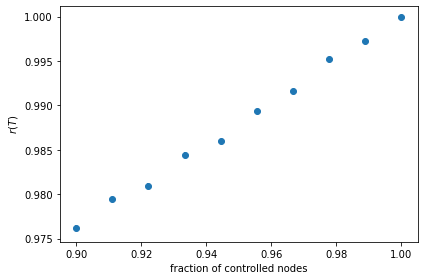

In [8]:
order_parameter_mean = np.array(order_parameter_mean)
order_parameter_std = np.array(order_parameter_std)

plt.figure()
plt.errorbar(fractions,order_parameter_mean,yerr=order_parameter_std/np.sqrt(samples),fmt="o")
plt.xlabel(r"fraction of controlled nodes")
plt.ylabel(r"$r(T)$")
plt.tight_layout()
plt.show()

In [10]:
np.savetxt("WS_drivers_K015_zoom.csv",np.c_[order_parameter_mean,order_parameter_std],header="order parameter mean\t order parameter std")